<a href="https://colab.research.google.com/github/BurhanuddinLatsaheb/Speech-to-Image-Generation/blob/main/Speech_to_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font size = 2><span style="font-family:'Times New Roman';color:#03045e">🔊🔊Speech to Image 📷 Generation </span></font></b>  

<b><font size = 2><span style="font-family:'Times New Roman';color:#03045e;">Created By Burhanuddin Latsaheb </span></font> </b> 



#  <center><font size = 8><span style="color:#0077b6;font-family:'Times New Roman'">🔊🔊Speech to Image 📷 Generation</span></font></center>







<font size = 5><span style="color:#202833;font-family:'Times New Roman'">Notebook Overview : </span></font>

<!-- * <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> This notebook contains:  </span></font> -->
1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">This notebook contains a pipeline to convert Speech to Image with multi langual detection and translation with the help of Whisper model and Stable Diffusion</span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">This project was built for the competition <b> Stranger Hacks: GPT Era</b>.</span></font>

<a id = 1></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">IMPORTS </span></font></center>

In [4]:
!pip install diffusers --q
!pip install transformers scipy ftfy --q
!pip install "ipywidgets>=7,<8" --q
!pip install accelerate --q
!pip install ffmpeg-python --q
!pip install gradio --q
!pip install translators --q
!pip install langdetect --q
!pip install googletrans==4.0.0-rc1
from IPython.display import clear_output
clear_output()

In [5]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
from langdetect import detect
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
from PIL import Image
from googletrans import Translator
from langdetect import DetectorFactory
DetectorFactory.seed = 0


<a id = 2></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">WHISPER MODEL </span></font></center>

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">Whisper is an automatic speech recognition (ASR) system trained on 680,000 hours of multilingual and multitask supervised data collected from the web</span></font><br>

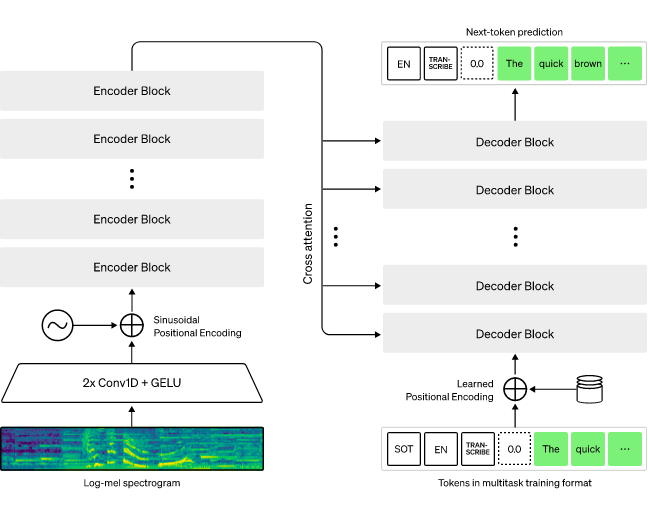

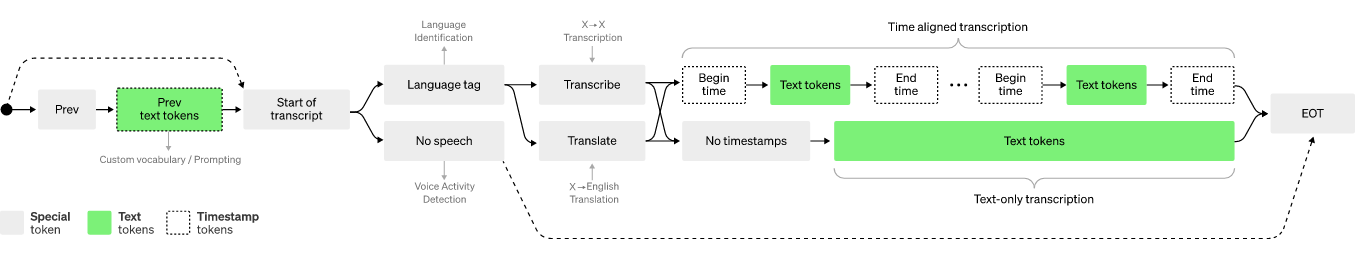

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The Whisper architecture is a simple end-to-end approach, implemented as an encoder-decoder Transformer. Input audio is split into 30-second chunks, converted into a log-Mel spectrogram, and then passed into an encoder. A decoder is trained to predict the corresponding text caption, intermixed with special tokens that direct the single model to perform tasks such as language identification, phrase-level timestamps, multilingual speech transcription, and to-English speech translation.
</span></font>



In [6]:
#@markdown Choose the whisper model <br>
#@markdown (If running on colab don't use whisper-large or whisper-largev2 due to VRAM issues)

MODEL_NAME = "openai/whisper-base" #@param ["openai/whisper-tiny","openai/whisper-small","openai/whisper-base", "openai/whisper-medium", "openai/whisper-large" , "openai/whisper-large-v2"]
processor = WhisperProcessor.from_pretrained(MODEL_NAME) 
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
model.config.forced_decoder_ids = None


<a id = 3></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">STABLE DIFFUSION MODEL </span></font></center>

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">Stable Diffusion is a latent text-to-image diffusion model. Thanks to a generous compute donation from Stability AI and support from LAION, we were able to train a Latent Diffusion Model on 512x512 images from a subset of the LAION-5B database. Similar to Google's Imagen, this model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM. See this section below and the model card.</span></font>

Stable Diffusion V1 :-
<br>
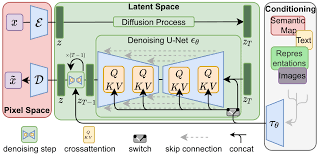

Stable Diffusion V2 :-
<br>
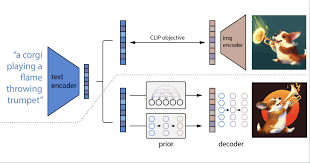

In [7]:
#@markdown Choose the Stable Diffusion Model
model_id = "stabilityai/stable-diffusion-2-1" #@param ["CompVis/stable-diffusion-v1-4","runwayml/stable-diffusion-v1-5","stabilityai/stable-diffusion-2-1", "stabilityai/stable-diffusion-2-1-base"]

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(



<a id = 4></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">AUDIO RECORDING </span></font></center>



<a id = 4.1></a>
## <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">Helper Function </span></font></center>


In [8]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    audioBitsPerSecond: 16000, //chrome seems to ignore, always 48k
    audioConstantBitRate: true,
    //mimeType : 'audio/webm;codecs=opus'
    mimeType : 'audio/webm;codecs=pcm'
  };            
  recorder = new MediaRecorder(stream, options);
  //recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


<a id = 4.2></a>
## <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">Record </span></font></center>



In [9]:
audio, sr = get_audio()
sf.write("speech.wav", audio, sr)

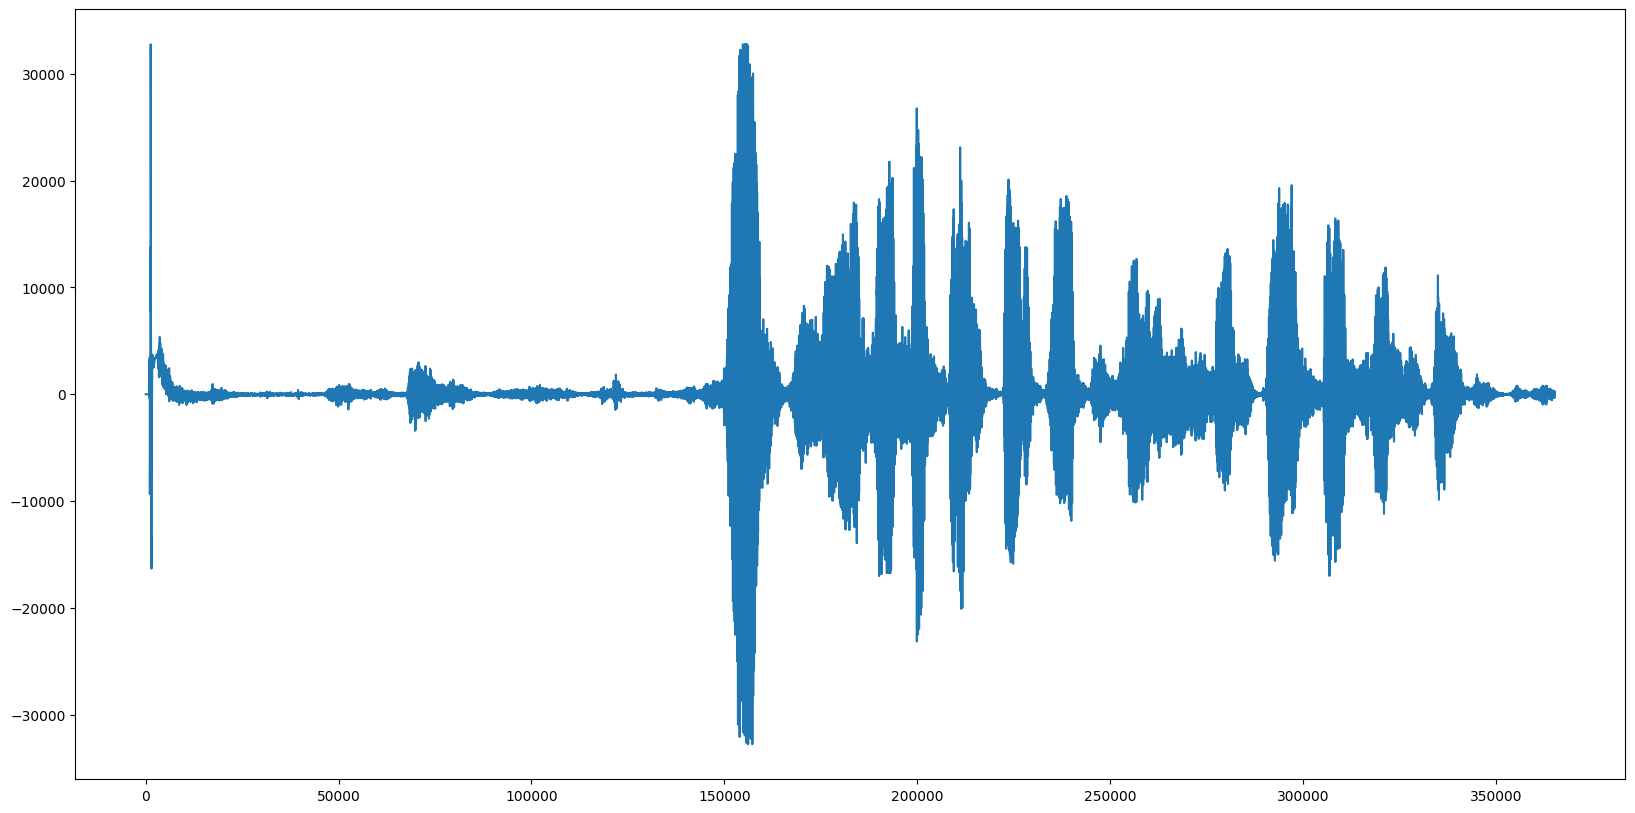

In [11]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [12]:
speech, sr = librosa.load('speech.wav', sr=16000) 


<a id = 5></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">SPEECH TO TEXT</span></font></center>



In [13]:
input_features = processor(speech, sampling_rate=sr, return_tensors="pt").input_features 
predicted_ids = model.generate(input_features)
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(transcription)

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[' An image of a fighter jet flying in the sky topgains time.']



<a id = 5.1></a>
## <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">Translation </span></font></center>



In [14]:
#@markdown Choose the Language you want to translate the audio into <br>
#@markdown English is the default language for stable diffusion
from googletrans import Translator
# Initialize Translator
translator = Translator()
# Detect the source language of the text
detected_language = translator.detect(transcription[0]).lang
dest = "en"  #@param {type:"string"}
# Translate the text to English
translated_text = translator.translate(transcription[0], dest='en').text
# Print the detected language and translated text
print(f"Detected language: {detected_language}")
print(f"Translated text: {translated_text}")
transcription[0] = translated_text + " 4k hd"

Detected language: en
Translated text: An image of a fighter jet flying in the sky topgains time.


['An image of a fighter jet flying in the sky topgains time. 4k hd']


<a id = 6></a>
# <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">📩 TEXT TO IMAGE🎨</span></font></center>



<a id = 6.1></a>
## <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">Helper Function </span></font></center>


In [15]:
def image_grid(imgs, rows, cols):
    # assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

<a id = 6.2></a>
## <center><font size = 6><span style="color:#202833;font-family:'Times New Roman'">Images Finally!!  </span></font></center>


  0%|          | 0/50 [00:00<?, ?it/s]

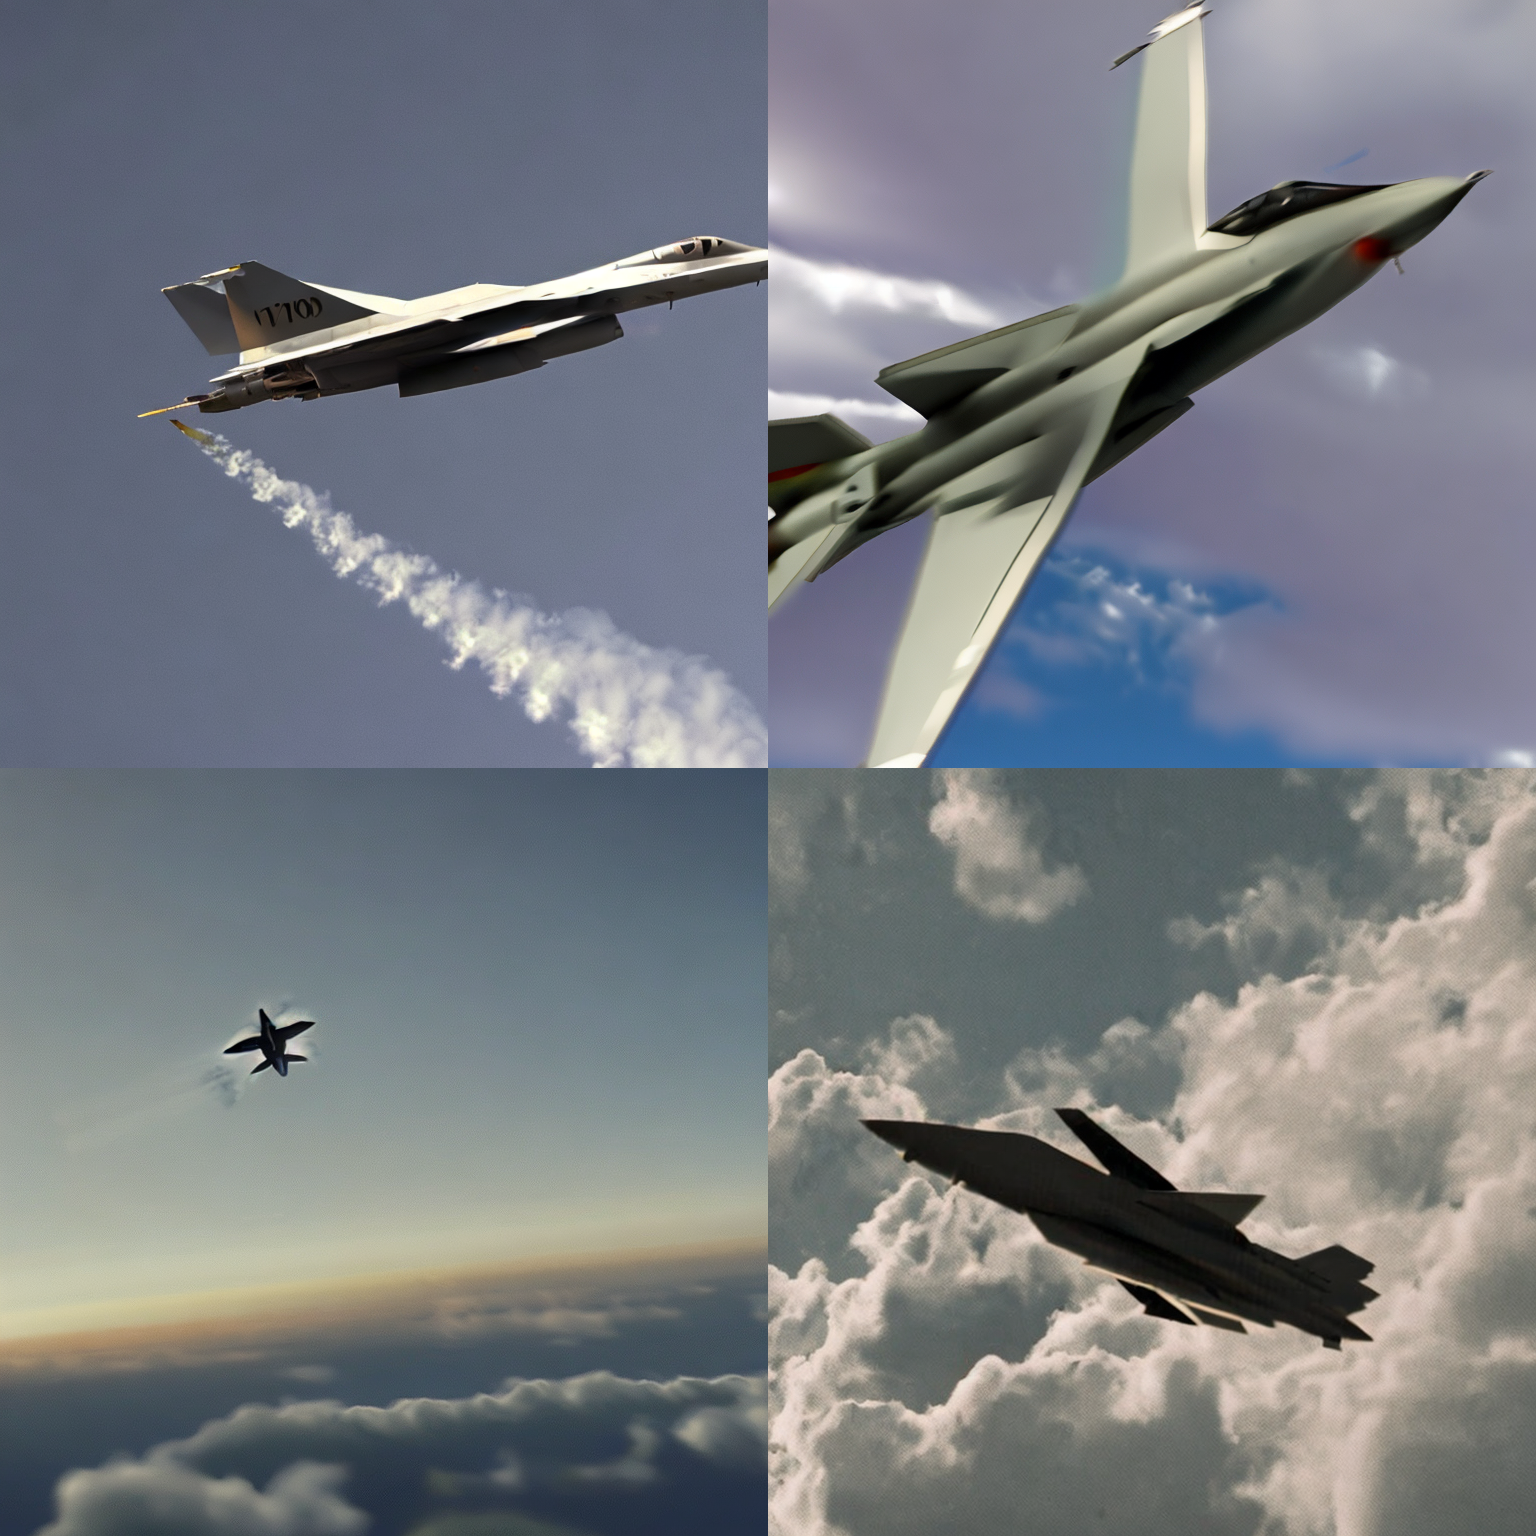

In [16]:
#@markdown Enter the beow parameters for number of images you want to generate
num_images = 4 #@param {type : "raw"}
inference_steps = 50 #@param {type : "raw"}
rows = 2  #@param {type : "raw"}
cols = 2 #@param {type : "raw"}

prompt = transcription * num_images
images = pipe(prompt , num_inference_steps=inference_steps).images
grid = image_grid(images, rows=rows, cols=cols)
grid